# Video Game Sales — Exploration, Preparation, Modeling

**Objective:** predict `total_sales` (global sales in millions) using provided features:
`img, title, console, genre, publisher, developer, critic_score, total_sales, na_sales, jp_sales, pal_sales, other_sales, release_date, last_update`.

This notebook follows the coursework practical requirements:
A) Load dataset
B) Exploratory Data Analysis (EDA)
C) Data preparation
D) Model training (3+ models)
E) Model evaluation
F) Save model & artifacts


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from datetime import datetime

# sklearn imports used later
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Notebook settings
%matplotlib inline
sns.set(style="whitegrid")
RANDOM_STATE = 42

## A. Load dataset
Load both CSV files:
- data/raw/vg_data_dictionary.csv  (meta/dictionary)
- data/raw/vg_sales_data.csv       (actual rows)

In [2]:
# paths
DATA_DIR = "./data"   # adjust if running from different working dir
dict_path = os.path.join(DATA_DIR, "vg_data_dictionary.csv")
data_path = os.path.join(DATA_DIR, "vg_sales_data.csv")

# load
vg_dict = pd.read_csv(dict_path)
df = pd.read_csv(data_path)

# quick checks
print("Dictionary shape:", vg_dict.shape)
print("Data shape:", df.shape)

display(vg_dict.head())
display(df.head())
df.info()


Dictionary shape: (14, 2)
Data shape: (64016, 14)


,Field,Description
0,img,URL slug for the box art at vgchartz.com
1,title,Game title
2,console,Console the game was released for
3,genre,Genre of the game
4,publisher,Publisher of the game


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   developer     63999 non-null  object 
 6   critic_score  6678 non-null   float64
 7   total_sales   18922 non-null  float64
 8   na_sales      12637 non-null  float64
 9   jp_sales      6726 non-null   float64
 10  pal_sales     12824 non-null  float64
 11  other_sales   15128 non-null  float64
 12  release_date  56965 non-null  object 
 13  last_update   17879 non-null  object 
dtypes: float64(6), object(8)
memory usage: 6.8+ MB


In [3]:
# expected rows ~64,016 (confirm)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())

# duplicates
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")

Rows: 64016
Columns: ['img', 'title', 'console', 'genre', 'publisher', 'developer', 'critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales', 'release_date', 'last_update']
Duplicate rows: 0


## B. Exploratory Data Analysis (EDA)
Include: summary statistics, correlation matrix, and useful plots.

In [4]:
# Numeric summary
display(df.describe())

# All columns summary (including object types)
display(df.describe(include='object').T)

# Missing values
display(df.isna().sum().sort_values(ascending=False))

,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,6678.000000,18922.000000,12637.000000,6726.000000,12824.000000,15128.000000
mean,7.220440,0.349113,0.264740,0.102281,0.149472,0.043041
std,1.457066,0.807462,0.494787,0.168811,0.392653,0.126643
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,0.030000,0.050000,0.020000,0.010000,0.000000
50%,7.500000,0.120000,0.120000,0.040000,0.040000,0.010000
75%,8.300000,0.340000,0.280000,0.120000,0.140000,0.030000
max,10.000000,20.320000,9.760000,2.130000,9.850000,3.120000


,count,unique,top,freq
img,64016,56177,/games/boxart/default.jpg,7810
title,64016,39798,Plants vs. Zombies,17
console,64016,81,PC,12617
genre,64016,20,Misc,9304
publisher,64016,3383,Unknown,8842
developer,63999,8862,Unknown,4435
release_date,56965,7922,1994-01-01,515
last_update,17879,1545,2018-01-06,165


critic_score    57338
jp_sales        57290
na_sales        51379
pal_sales       51192
other_sales     48888
last_update     46137
total_sales     45094
release_date     7051
developer          17
img                 0
title               0
console             0
genre               0
publisher           0
dtype: int64

Numeric columns: ['critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']


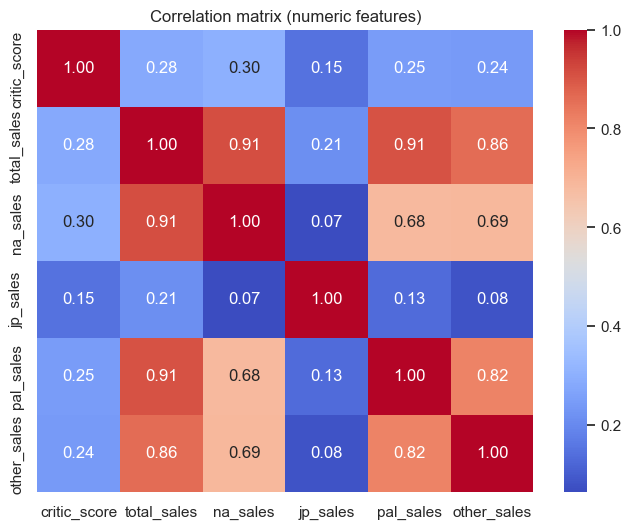

In [5]:
# Select numeric columns
numeric_cols = ['critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']
print("Numeric columns:", numeric_cols)

corr = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix (numeric features)")
plt.show()

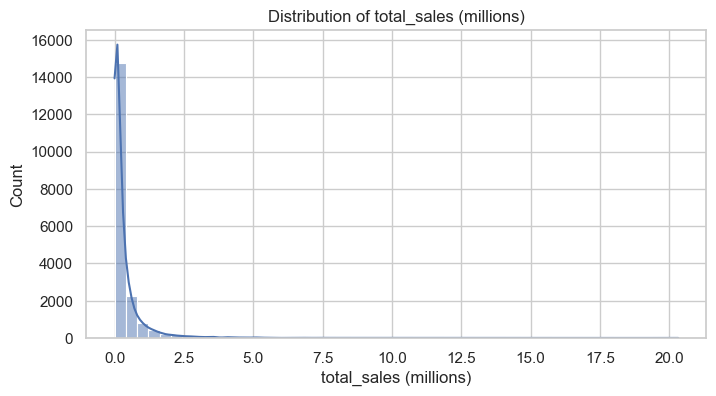

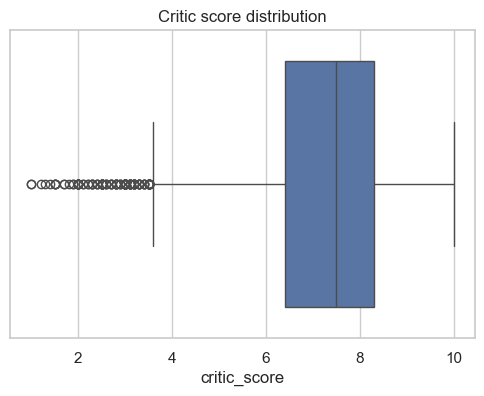

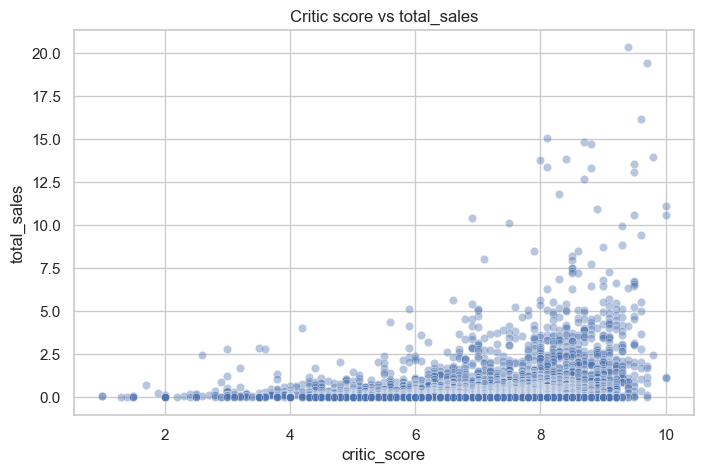

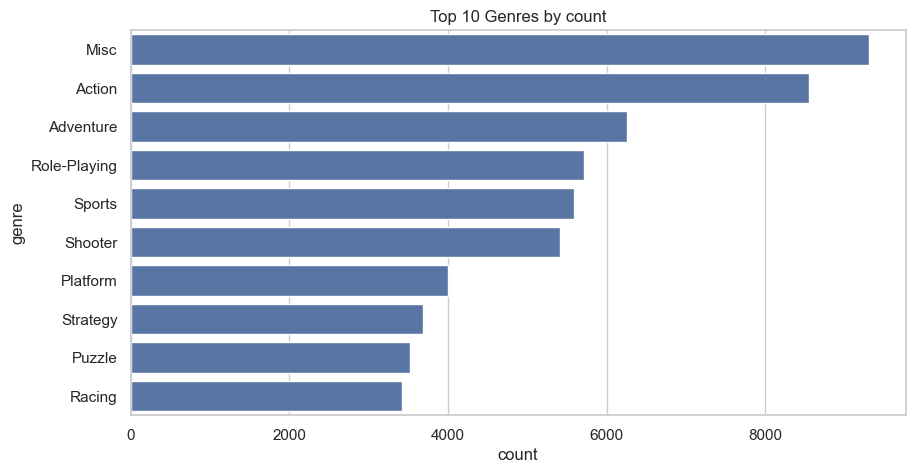

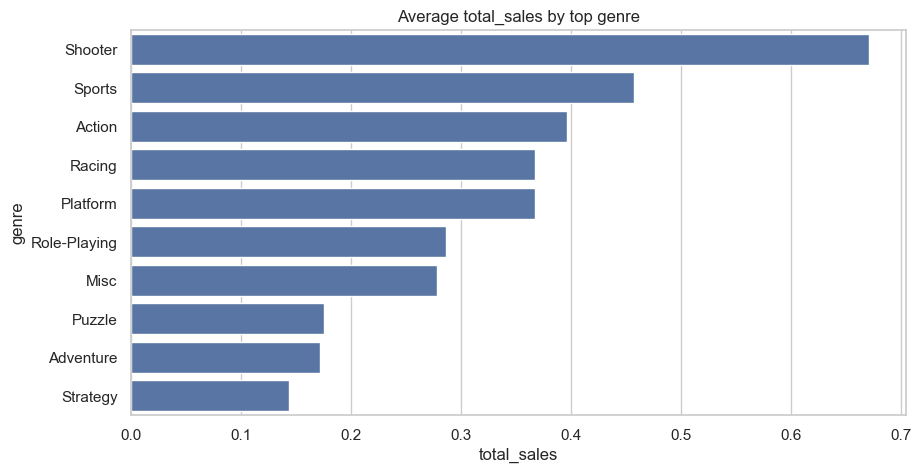

In [6]:
# 1. Histogram of total_sales
plt.figure(figsize=(8,4))
sns.histplot(df['total_sales'].dropna(), bins=50, kde=True)
plt.title("Distribution of total_sales (millions)")
plt.xlabel("total_sales (millions)")
plt.show()

# 2. Boxplot for critic_score
plt.figure(figsize=(6,4))
sns.boxplot(x=df['critic_score'])
plt.title("Critic score distribution")
plt.show()

# 3. Scatter: critic_score vs total_sales (add jitter for readability)
plt.figure(figsize=(8,5))
sns.scatterplot(x='critic_score', y='total_sales', data=df, alpha=0.4)
plt.title("Critic score vs total_sales")
plt.show()

# 4. Top 10 genres by count and their mean total_sales
top_genres = df['genre'].value_counts().nlargest(10).index
plt.figure(figsize=(10,5))
sns.countplot(y='genre', data=df[df['genre'].isin(top_genres)], order=top_genres)
plt.title("Top 10 Genres by count")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='total_sales', y='genre', data=df[df['genre'].isin(top_genres)].groupby('genre')['total_sales'].mean().reset_index().sort_values('total_sales', ascending=False))
plt.title("Average total_sales by top genre")
plt.show()

## C. Data Preparation
Tasks:
- Fix dtypes and convert `release_date` & `last_update` to datetime
- Handle missing values
- Correct obvious data errors (e.g., critic_score range)
- Encode categorical features (via pipeline)
- Split dataset into train / validation / test

In [7]:
# Convert date columns to datetime
for col in ['release_date', 'last_update']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Show rows with invalid dates, if any
print("Rows with missing/invalid release_date:", df['release_date'].isna().sum())

# critic_score cleaning: replace impossible values (keep NaNs for imputation later)
print("critic_score min/max before:", df['critic_score'].min(), df['critic_score'].max())
df.loc[(df['critic_score'] < 0) | (df['critic_score'] > 10), 'critic_score'] = np.nan
print("critic_score after cleaning min/max (NaNs remain):", df['critic_score'].min(), df['critic_score'].max())

# Remove complete duplicates if any
df = df.drop_duplicates().reset_index(drop=True)
print("After dropping duplicates, shape:", df.shape)

Rows with missing/invalid release_date: 7051
critic_score min/max before: 1.0 10.0
critic_score after cleaning min/max (NaNs remain): 1.0 10.0
After dropping duplicates, shape: (64016, 14)


In [8]:
# Missing counts
missing = df.isna().sum()
display(missing[missing > 0])

# Strategy:
# - numeric: critic_score -> median imputation
# - categorical: genre/publisher/developer -> fill 'Unknown' if missing
# - dates: if release_date missing -> drop or set to '1970-01-01' (we'll drop if very few)

developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
last_update     46137
dtype: int64

In [9]:
# Fill categorical missing values with 'Unknown' (non-persistent if you want to keep raw data untouched, make a copy)
df_prep = df.copy()
for col in ['genre','publisher','developer','console','title']:
    df_prep[col] = df_prep[col].fillna('Unknown')

# If release_date missing is small, drop those rows (document this decision)
release_missing = df_prep['release_date'].isna().sum()
print("release_date missing rows:", release_missing)
if release_missing > 0 and release_missing / len(df_prep) < 0.02:
    df_prep = df_prep[~df_prep['release_date'].isna()].copy()
    print("Dropped rows with missing release_date. New shape:", df_prep.shape)
else:
    print("Keep rows with missing release_date for pipeline handling.")

release_date missing rows: 7051
Keep rows with missing release_date for pipeline handling.


In [10]:
# We will engineer 'release_year' inside the pipeline using a transformer.
# For demonstration here, we'll show how to derive it on a working copy (not required to write to CSV).
df_prep['release_year'] = df_prep['release_date'].dt.year
display(df_prep[['title','release_date','release_year']].head())
# But the modelling pipeline below will also compute release_year from release_date at runtime.

,title,release_date,release_year
0,Grand Theft Auto V,2013-09-17,2013.0
1,Grand Theft Auto V,2014-11-18,2014.0
2,Grand Theft Auto: Vice City,2002-10-28,2002.0
3,Grand Theft Auto V,2013-09-17,2013.0
4,Call of Duty: Black Ops 3,2015-11-06,2015.0


In [11]:
# Define features and target
FEATURE_COLS = ['console','genre','publisher','developer','critic_score','na_sales','jp_sales','pal_sales','other_sales','release_date']
TARGET = 'total_sales'

# Preselect rows with non-null target
df_model = df.copy()
df_model = df_model[~df_model[TARGET].isna()].reset_index(drop=True)

# For pipeline convenience, keep release_date as datetime in df_model
df_model['release_date'] = pd.to_datetime(df_model['release_date'], errors='coerce')

# Split: train 70%, val 15%, test 15%
X = df_model[FEATURE_COLS]
y = df_model[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (13245, 10) Val: (2838, 10) Test: (2839, 10)


## D. Models Training
We will train 3 models:
1. Ridge Regression (linear baseline)
2. RandomForestRegressor (tree-based)
3. GradientBoostingRegressor (boosting)
We will use `ColumnTransformer` + `Pipeline` to handle categorical encoding and numeric scaling.

In [12]:
# Preprocessing for numeric and categorical features
numeric_features = ['critic_score','na_sales','jp_sales','pal_sales','other_sales']
categorical_features = ['console','genre','publisher','developer']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
], remainder='drop')

In [13]:
# Model pipelines
pipe_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', Ridge(random_state=RANDOM_STATE))])

pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))])

pipe_gb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))])

In [15]:
from sklearn.metrics import mean_squared_error

# Train ridge
pipe_ridge.fit(X_train[numeric_features + categorical_features], y_train)
pred_ridge = pipe_ridge.predict(X_val[numeric_features + categorical_features])

# RMSE
rmse = mean_squared_error(y_val, pred_ridge)
print("Ridge val RMSE:", rmse)

Ridge val RMSE: 0.001797635182356742


In [ ]:
# Hyperparameter tuning for RandomForest (example with RandomizedSearch)
from scipy.stats import randint as sp_randint

rf_param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

rf_search = RandomizedSearchCV(pipe_rf, rf_param_dist, n_iter=6, cv=3, scoring='neg_root_mean_squared_error', random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
rf_search.fit(X_train[numeric_features + categorical_features], y_train)
print("Best RF params:", rf_search.best_params_)
print("Best RF CV score (neg RMSE):", rf_search.best_score_)
best_rf = rf_search.best_estimator_

In [18]:
gb_param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}
gb_search = GridSearchCV(pipe_gb, gb_param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gb_search.fit(X_train[numeric_features + categorical_features], y_train)
print("Best GB params:", gb_search.best_params_)
best_gb = gb_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best GB params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}


In [20]:
## E. Model Evaluation (use test set)

def evaluate_model(model, X_test, y_test, name="model"):
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
    return {'name': name, 'RMSE':rmse, 'MAE':mae, 'R2':r2}

# Prepare the test X subset
X_test_sub = X_test[numeric_features + categorical_features]

results = []
results.append(evaluate_model(pipe_ridge, X_test_sub, y_test, "Ridge"))
results.append(evaluate_model(best_rf, X_test_sub, y_test, "RandomForest"))
results.append(evaluate_model(best_gb, X_test_sub, y_test, "GradientBoosting"))

# Create comparison DataFrame
results_df = pd.DataFrame(results).set_index('name').round(4)
display(results_df)

Ridge -> RMSE: 0.0018, MAE: 0.0309, R2: 0.9980
RandomForest -> RMSE: 0.0142, MAE: 0.0186, R2: 0.9844
GradientBoosting -> RMSE: 0.0037, MAE: 0.0199, R2: 0.9959


,RMSE,MAE,R2
name,,,
Ridge,0.0018,0.0309,0.9980
RandomForest,0.0142,0.0186,0.9844
GradientBoosting,0.0037,0.0199,0.9959


Best model on test set: Ridge


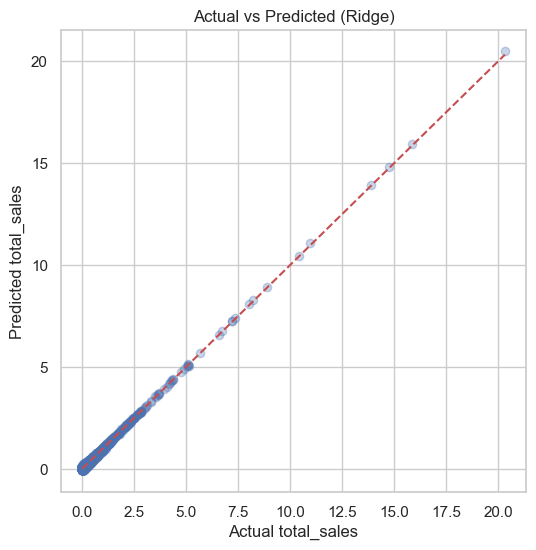

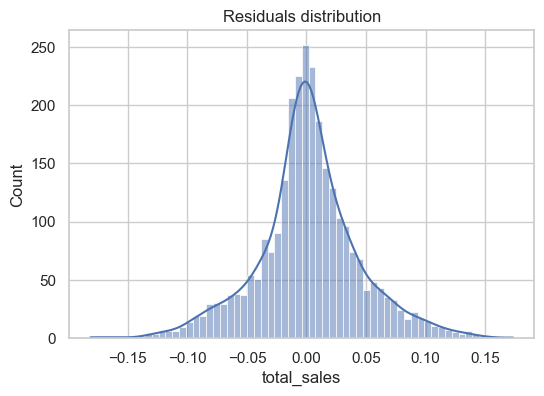

In [23]:
# pick best by RMSE
best_name = results_df['RMSE'].idxmin()
print("Best model on test set:", best_name)

if best_name == "RandomForest":
    chosen_model = best_rf
elif best_name == "GradientBoosting":
    chosen_model = best_gb
else:
    chosen_model = pipe_ridge

y_pred = chosen_model.predict(X_test_sub)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual total_sales")
plt.ylabel("Predicted total_sales")
plt.title(f"Actual vs Predicted ({best_name})")
plt.show()

# residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residuals distribution")
plt.show()

In [25]:
## F. Save final model and preprocessing pipeline

# Save best pipeline (which includes preprocessor) to models/
os.makedirs("../models", exist_ok=True)
joblib.dump(chosen_model, "../models/best_model_pipeline.joblib")
print("Saved best model pipeline to models/best_model_pipeline.joblib")

Saved best model pipeline to models/best_model_pipeline.joblib


## G. Reproducibility & Streamlit

- Save pip packages to `requirements.txt` (file included in repo).
- To run notebook: create venv, install requirements, run `jupyter lab` or `jupyter notebook`.
- To run app: `streamlit run app/streamlit_app.py`